## Keras implementation of https://phillipi.github.io/pix2pix

In [1]:
import os
os.environ['KERAS_BACKEND']='theano' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile'

In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

Using Theano backend.
Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 980 (0000:01:00.0)


In [3]:
# Weights initializations
# bias are initailized as 0
conv_init = RandomNormal(0, 0.02) # for convolution kernel
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [4]:
# Basic discriminator
def BASIC_D(nc, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    use_batchnorm = True 
    _ = inputs = Input(shape=(nc, 256, 256))
    _ = Conv2D(ndf, kernel_size=4, strides=2, padding = "same", kernel_initializer = conv_init, name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = ZeroPadding2D(1)(_)
        _ = Conv2D(out_feat, kernel_size=4, strides=2, use_bias=(not use_batchnorm),
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        if use_batchnorm:
            _ = BatchNormalization(momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(filters=out_feat, kernel_size=4,  use_bias=(not use_batchnorm),                    
                    kernel_initializer = conv_init,
                    name = 'pyramid_last') (_)
    if use_batchnorm:
        _ = BatchNormalization(momentum=0.9, axis=1, epsilon=1.01e-5,
                           gamma_initializer = gamma_init, 
                              )(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = Conv2D(filters=1, kernel_size=4,                   
                    kernel_initializer = conv_init,
                    name = 'final'.format(out_feat, 1),
                    activation = "sigmoid"
                    ) (_)    
    return Model(inputs=inputs, outputs=_)

In [5]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    conv_layers = []
    s = isize if fixed_input_size else None
    _ = inputs = Input(shape=(nc_in, s, s))
    # Down sampling
    tsize = isize    
    #use_batchnorm = False
    while True:
        assert tsize>=2 and tsize%2==0
        filters = ngf * min(2**len(conv_layers), 8)
        use_batchnorm = len(conv_layers)>1 and tsize>2
        _ = ZeroPadding2D(1)(_)
        _ = Conv2D(filters, kernel_size=4, strides=2, use_bias=(not use_batchnorm),
                   kernel_initializer = conv_init,
                   name = 'conv.{0}'.format(len(conv_layers))
                        ) (_)   
        if tsize==2:
            break        
        if use_batchnorm:
             _ = BatchNormalization(momentum=0.9, axis=1, epsilon=1.01e-5,
                 gamma_initializer = gamma_init)(_, training=1)
        conv_layers.append(_)
        _ = LeakyReLU(alpha=0.2)(_)
        tsize = tsize // 2
    # Up sampling
    use_batchnorm = True
    while tsize<isize:
        _ = Activation("relu")(_)           
        filters = ngf * min(2**(len(conv_layers)-1), 8)
        _ = Conv2DTranspose(filters, kernel_size=4, strides=2, use_bias=(not use_batchnorm),
                            kernel_initializer = conv_init,                           
                            name = 'convt.{0}'.format(len(conv_layers)))(_)        
        _ = Cropping2D(1)(_)
        if use_batchnorm:
            _ = BatchNormalization(momentum=0.9, axis=1, epsilon=1.01e-5,
                 gamma_initializer = gamma_init)(_, training=1)
        if tsize <=8:
            _ = Dropout(0.5)(_, training=1)
        _ =Concatenate(axis=1)([conv_layers.pop(), _])
        tsize*=2
    _ = Activation("relu")(_)
    _ = Conv2DTranspose(nc_out, kernel_size=4, strides=2,
                            kernel_initializer = conv_init,
                            name = 'last')(_)
    _ = Cropping2D(1)(_)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])


In [6]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [7]:
netD = BASIC_D(nc_in+nc_out, ndf)
netD.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6, 256, 256)       0         
_________________________________________________________________
First (Conv2D)               (None, 64, 128, 128)      6208      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 128, 128)      0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 64, 130, 130)      0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 128, 64, 64)       131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64, 64)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 64, 64)       0         
__________

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netG = UNET_G(imageSize, nc_in, nc_out, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netG.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 256, 256)   0                                            
____________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D) (None, 3, 258, 258)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv.0 (Conv2D)                  (None, 64, 128, 128)  3136        zero_padding2d_5[0][0]           
____________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)        (None, 64, 128, 128)  0           conv.0[0][0]                     
___________________________________________________________________________________________

In [9]:
from keras.optimizers import RMSprop, SGD, Adam

In [10]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])

real_B = Input(shape=(nc_out, imageSize, imageSize))
real_AB = Concatenate(axis=1)([real_A, real_B])
fake_AB = Concatenate(axis=1)([real_A, fake_B])
output_D_real = netD(real_AB)
output_D_fake = netD(fake_AB)

In [11]:
#loss_fn = lambda output, target : K.mean(K.sum(K.binary_crossentropy(output, target), axis=[1,2,3]))
loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))
#loss_L1 = K.mean(K.sum(K.abs(fake_B-real_B), axis=[1,2,3]))
loss_L1 = K.mean(K.abs(fake_B-real_B))

In [12]:
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

In [13]:
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)



In [14]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    arr = np.moveaxis(arr, 2, 0)
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[:, h1:h2, loadSize+w1:loadSize+w2]
    imgB = arr[:, h1:h2, w1:w2]
    if randint(0,1):
        imgA=imgA[:,:,::-1]
        imgB=imgB[:,:,::-1]
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

data = "edges2shoes"
data = "facades"
direction = 0
trainAB = load_data('pix2pix/{}/train/*.jpg'.format(data))
valAB = load_data('pix2pix/{}/val/*.jpg'.format(data))
assert len(trainAB) and len(valAB)

In [15]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [16]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

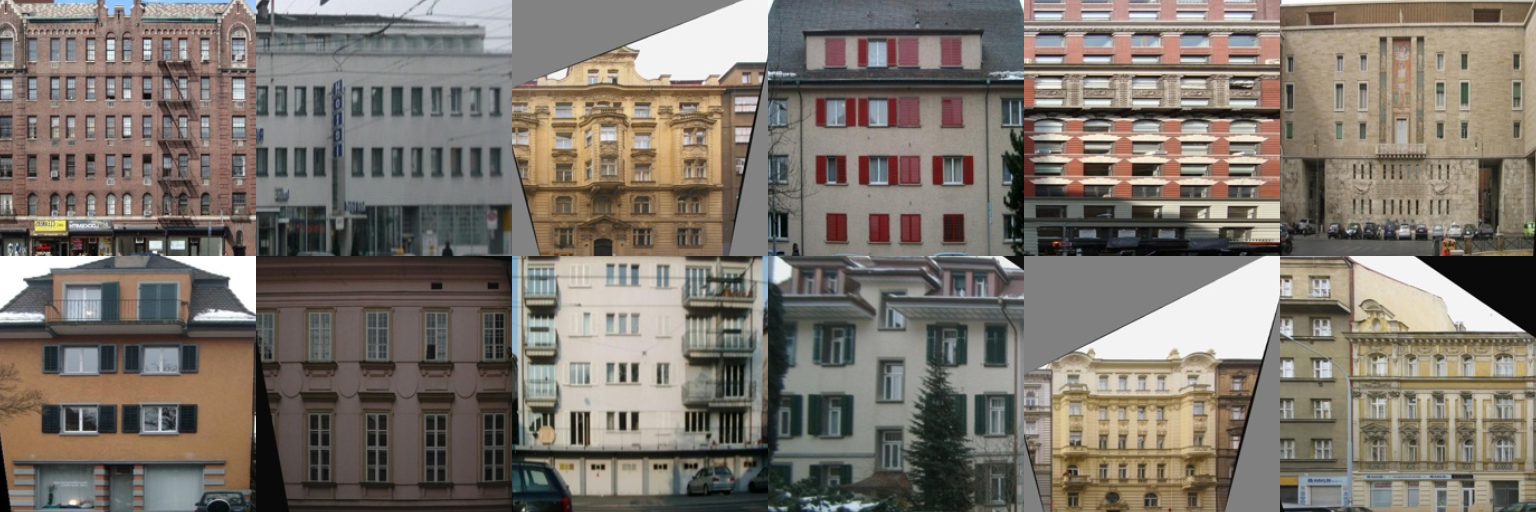

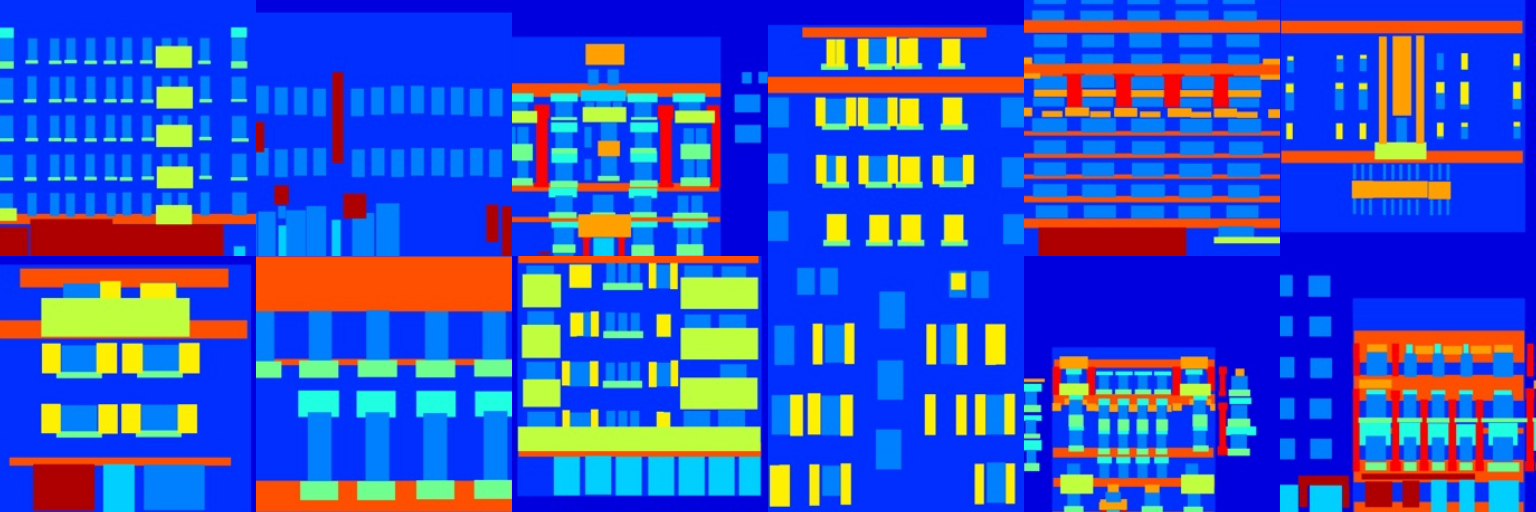

In [17]:
train_batch = minibatch(trainAB, 12, direction=1)
_, trainA, trainB = next(train_batch)
showX(trainA, 2)
showX(trainB, 2)
del train_batch, trainA, trainB

In [ ]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

In [ ]:
import time
t0 = time.time()
niter = 50
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    # epoch, trainA, trainB = next(train_batch)
    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        